#**0. Thư viện**

##Cài đặt 

In [ ]:
!pip3 install adabound
# !pip3 numpy torc sklearn matplotlib pandas

In [ ]:
# Lib for print table
!pip3 install prettytable

##Import

In [ ]:
# Add Module Path - To Import Custom Modules
# Modules Path
ModulePath = "/content/drive/My Drive/Study/KLTN/Google Colab/0.0 Python Modules/"

import sys
sys.path.append(ModulePath)

In [ ]:
import numpy as np
import pandas as pd
import torch as th
from torch.autograd import Variable as V
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

# Libs for Keras
from keras.models import load_model


# Own Custom Module to import models and constants
from models import *
from constants import *

import matplotlib.pyplot as plt
import adabound 
import math
from prettytable import PrettyTable
import os
from datetime import date
import timeit

#**1. Chuẩn bị**

##Paths

In [ ]:
# Dataset Path
Dataset_Path = "/content/drive/My Drive/Study/KLTN/Dataset/NSL-KDD Processed/Final - For Using/"
Trainsets_Path = Dataset_Path + 'Trainset/'
# Trainset
g_trainset_path = Trainsets_Path + "GAN-G.csv"
d_trainset_path = Trainsets_Path + "GAN-D.csv"
# Testset
testset_path = Dataset_Path + "Testset/" + "KDDTest+.csv"

# Saved Models Path
SavedModelPath = "/content/drive/My Drive/Study/KLTN/Saved Model/"

# GAN Saved Models Paths
GAN_Model_Path = SavedModelPath + 'GANModel/'

# Blackbox IDS
IDS_DOS_ModelPath = SavedModelPath + "IDSModel/DOS/" + "Keras_CNN.h5"
IDS_U2R_AND_R2L_ModelPath = SavedModelPath + "IDSModel/U2R_AND_R2L/" + "Keras_CNN.h5"
ids_model_path = {'DOS': IDS_DOS_ModelPath, 'U2R_AND_R2L': IDS_U2R_AND_R2L_ModelPath}

##Global Variables

In [ ]:
# Global Variables
N_FEATURES = 41
ATTACK_CATEGORIES = ['DOS', 'U2R_AND_R2L']
POS_FUNCTIONAL_FEATURES = {'DOS': DOS_FEATURES, 'U2R_AND_R2L': U2R_AND_R2L_FEATURES}

POS_NONFUNCTIONAL_FEATURES = {}
for attack_category, pos_functional_feature in POS_FUNCTIONAL_FEATURES.items():
    pos_nonfunctional_feature = []
    for i in range(N_FEATURES):
        if i not in pos_functional_feature:
            pos_nonfunctional_feature.append(i)
    POS_NONFUNCTIONAL_FEATURES[attack_category] = pos_nonfunctional_feature

In [ ]:
print('Position of Functional Features\n  ', POS_FUNCTIONAL_FEATURES)
print('Position of Functional Features:\n  ', POS_NONFUNCTIONAL_FEATURES)

Position of Functional Features
   {'DOS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30], 'U2R_AND_R2L': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]}
Position of Functional Features:
   {'DOS': [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], 'U2R_AND_R2L': [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]}


##Chuẩn bị dataset

# **2. Định nghĩa Model**

##Models

In [ ]:
# GAN Model
# GAN - Generator
class Generator(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim //2, input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim // 2, input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim//2,input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim//2,output_dim),
            # 08/05 - Add Tanh func.
            nn.Tanh()
        )
    def forward(self, z):
        generator_output = self.layer(z)
        return th.clamp(generator_output,0.,1.)

# GAN - Discriminator
class Discriminator(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim * 2, input_dim *2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim*2 , input_dim*2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim*2,input_dim//2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim//2,output_dim)
        )
    def forward(self,x):
        return self.layer(x)

##Functions

In [ ]:
# Hàm tạo Aversarial Attack Traffic
def create_adversarial_attack_traffic(generator_out, raw_attack, attack_category):
    if attack_category != 'DOS' and attack_category != 'U2R_AND_R2L':
        raise ValueError("Preprocess Data Fail: Invalid Attack Category")
    pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES[attack_category]
    # Keep the functional features
    adversarial_attack = raw_attack.clone()
    for idx in range(len(adversarial_attack)):
        adversarial_attack[idx][pos_nonfunctional_feature] = generator_out[idx]
    return adversarial_attack

# Compute Gradient Penalty
def compute_gradient_penalty(D, normal_t, attack_t):
    alpha = th.Tensor(np.random.random((normal_t.shape[0], 1)))
    between_n_a = (alpha * normal_t + ((1 - alpha) * attack_t)).requires_grad_(True)
    d_between_n_a = D(between_n_a)
    adv = V(th.Tensor(normal_t.shape[0], 1).fill_(1.0), requires_grad=False)

    gradients = autograd.grad(
        outputs=d_between_n_a,
        inputs=between_n_a,
        grad_outputs=adv,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Hàm tạo Batch
def create_batch2(x,batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    batch_x = [x[batch_size * i : (i+1)*batch_size,:] for i in range(len(x)//batch_size)]
    return np.array(batch_x)

# Hàm tiền xử lý dữ liệu tấn công
def preprocess_malicious_data(dataset, attack_category):
    # 2 Category: DoS, U2R&R2L
    if attack_category != 'DOS' and attack_category != 'U2R_AND_R2L':
      raise ValueError("Preprocess Data Fail: Invalid Attack Category")
    if attack_category == 'DOS':
      # DOS 
      attack_data = dataset[dataset['class'] == 'DOS']
    else:
      # U2R_AND_R2L
      attack_data = dataset[dataset['class'] == 'U2R_AND_R2L']
    # Del label
    del attack_data["class"]
    return np.array(attack_data)

# **3. Run Model**

##**3.1 Run IDSGAN**

In [ ]:
# Hyber Parameters and Create GAN-D
BATCH_SIZE = 64
MAX_EPOCH = 100
learning_rate = 0.0001
LAMBDA = 10
CLAMP = 0.01
CRITIC_ITERS = 5          # For WGAN and WGAN-GP, number of critic iters per gen iter

# Create GAN-D
D_INPUT_DIM = N_FEATURES
D_OUTPUT_DIM = 1
discriminator = Discriminator(D_INPUT_DIM,D_OUTPUT_DIM)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=learning_rate)

# GAN-G Dimension
NOISE_DIM = 9
G_INPUT_DIM = NOISE_DIM     # Generator input dimension is dimention of noise

In [ ]:
# Environment Variable and Load Dataset
ids_model_name = 'CNN'
adversarial_attack_type = 'AdversarialAttack2'

# Create Folder for save GAN adversarial with IDS Model.
GAN_4IDS_Model_Path = str(f"{GAN_Model_Path}{ids_model_name}/")
directory = GAN_4IDS_Model_Path
if not os.path.exists(directory):
        os.makedirs(directory)

today = str(date.today())

## Prepare Dataset
g_train_data = pd.read_csv(g_trainset_path)
d_train_data = pd.read_csv(d_trainset_path)

del d_train_data["class"]
normal = np.array(d_train_data)

print("Amout of Generator Trainset:", g_train_data.shape[0])
print("Amout of Discriminator Trainset:", d_train_data.shape[0])

Amout of Generator Trainset: 23488
Amout of Discriminator Trainset: 33672


----------------------------------------TRAINING GAN----------------------------------------
 Type : AdversarialAttack2
 -> Attack Category: DOS; IDS Model: CNN
 -> Load IDS Model from: /content/drive/My Drive/Study/KLTN/Saved Model/IDSModel/DOS/Keras_CNN.h5
 -> GAN-G Created:
               - Noise Dimension = 9
               - Number of Non-functional Features:24
***IDSGAN start training
     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)      Runtime(s)
         1           -1.62           -2.95           98.49            6.76           39.30
         2           -5.38           -2.17           98.49            3.21           34.96
         3           -8.13           -1.85           98.49            2.50           34.06
         4           -8.26           -1.77           98.49            2.50           34.38
         5           -8.24           -1.75           98.49            2.50           34.24
         6           -8.49           -1.76           98.49  

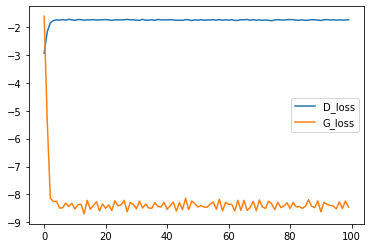

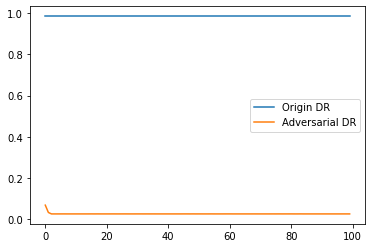

      -> Saved Discrimninator 100 epoch to: /content/drive/My Drive/Study/KLTN/Saved Model/GANModel/CNN/DOS/Discriminator/temp/AdversarialAttack2/dublicate_run/101epoch_time_created_2020-07-04.pth
----------------------------------------TRAINING GAN----------------------------------------
 Type : AdversarialAttack2
 -> Attack Category: U2R_AND_R2L; IDS Model: CNN
 -> Load IDS Model from: /content/drive/My Drive/Study/KLTN/Saved Model/IDSModel/U2R_AND_R2L/Keras_CNN.h5
 -> GAN-G Created:
               - Noise Dimension = 9
               - Number of Non-functional Features:18
***IDSGAN start training
     Epoch          G-Loss          D-Loss         O-DR(%)         A-DR(%)      Runtime(s)
         1           -6.75           -0.90           78.11            0.78           30.44
         2           -5.26           -0.99           78.11            0.78           29.97
         3           -4.99           -0.95           78.11            0.75           29.10
         4           -5.10   

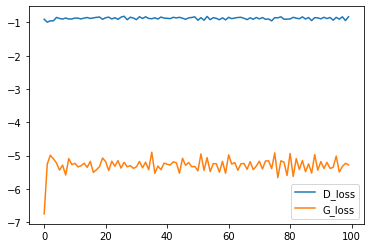

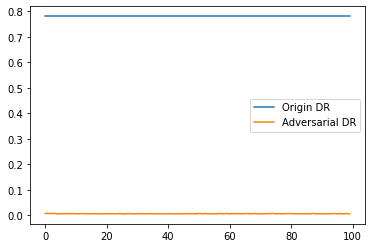

      -> Saved Discrimninator 100 epoch to: /content/drive/My Drive/Study/KLTN/Saved Model/GANModel/CNN/U2R_AND_R2L/Discriminator/temp/AdversarialAttack2/dublicate_run/101epoch_time_created_2020-07-04.pth


In [ ]:
# Training GAN
for attack_category in ATTACK_CATEGORIES:
    total_time_start = timeit.default_timer()
    print(f"{40*'-'}TRAINING GAN{40*'-'}")
    print(f" Type : {adversarial_attack_type}")
    print(f" -> Attack Category: {attack_category}; IDS Model: {ids_model_name}")
    # Load IDS Model
    ids_model = load_model(ids_model_path[attack_category])
    print(f" -> Load IDS Model from: {ids_model_path[attack_category]}")
    # ids_model.summary()

    # Create GAN-G model
    G_OUTPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES[attack_category])     # Generator output is number of nonfunctional feature
    generator = Generator(G_INPUT_DIM,G_OUTPUT_DIM)
    print(f" -> GAN-G Created:\n{15*' '}- Noise Dimension = {G_INPUT_DIM}\n{15*' '}- Number of Non-functional Features:{G_OUTPUT_DIM}")
    optimizer_G = optim.RMSprop(generator.parameters(), lr=learning_rate)

    # Load Raw Attack Dataset
    raw_attack = preprocess_malicious_data(g_train_data, attack_category)

    # Prepare Save Folders
    GAN_G_Model_4Category_Path = str(f"{GAN_4IDS_Model_Path}{attack_category}/Generator/temp/{adversarial_attack_type}/dublicate_run/")
    GAN_D_Model_4Category_Path = str(f"{GAN_4IDS_Model_Path}{attack_category}/Discriminator/temp/{adversarial_attack_type}/dublicate_run/")
    for directory in [GAN_G_Model_4Category_Path, GAN_D_Model_4Category_Path]:
        if not os.path.exists(directory):
            os.makedirs(directory)

    # Declare Loss
    d_losses,g_losses, o_dr, a_dr = [],[], [], []
    generator.train()
    discriminator.train()

    # Create batch attack
    batch_attack = create_batch2(raw_attack,BATCH_SIZE)

    # Start Training
    print(f"***IDSGAN start training")
    labels = ['Epoch', 'G-Loss', 'D-Loss', 'O-DR(%)', 'A-DR(%)', 'Runtime(s)']
    print("{: >10} {: >15} {: >15} {: >15} {: >15} {: >15}".format(*labels))
    for epoch in range(MAX_EPOCH):
        epoch_time_start = timeit.default_timer()
        cnt = 0
        batch_normal = create_batch2(normal,BATCH_SIZE)
        run_g_loss = 0.
        run_d_loss = 0.
        epoch_o_drs, epoch_a_drs = [], []
        for idx, bn in enumerate(batch_normal):
            normal_b = th.Tensor(bn.astype("float64"))
            attack_traffic = V(th.Tensor(batch_attack[idx % len(batch_attack)]))
            #  Train Generator
            for p in discriminator.parameters():  
                p.requires_grad = False
            optimizer_G.zero_grad()        
            # GAN-G Generate Adversarial Attack
            noise = V(th.Tensor(np.random.uniform(0,1,(BATCH_SIZE, NOISE_DIM))))
            generator_out = generator(noise)
            adversarial_attack = create_adversarial_attack_traffic(generator_out, attack_traffic, attack_category)
            # GAN-D predict, GAN-G update parameter
            D_pred = discriminator(adversarial_attack)
            g_loss = -th.mean(D_pred)
            g_loss.backward()
            optimizer_G.step()            
            run_g_loss += g_loss.item()

            # Train Discreminator
            for p in discriminator.parameters(): 
                p.requires_grad = True
            for c in range(CRITIC_ITERS):
                optimizer_D.zero_grad()
                for p in discriminator.parameters():
                    p.data.clamp_(-CLAMP, CLAMP)
                # GAN-G Generate Adversarial Attack
                noise = V(th.Tensor(np.random.uniform(0,1,(BATCH_SIZE, NOISE_DIM))))
                generator_out = generator(noise)
                adversarial_attack = create_adversarial_attack_traffic(generator_out, attack_traffic, attack_category)
                # Make data to feed IDS
                ids_input = th.cat((adversarial_attack,normal_b))
                l = list(range(len(ids_input)))
                np.random.shuffle(l)
                ids_input = V(th.Tensor(ids_input[l]))
                ids_input_keras = ids_input.reshape(ids_input.shape[0], N_FEATURES, 1)
                ids_out = ids_model.predict(ids_input_keras)
                ids_pred_lable = np.argmax((ids_out),axis = 1)
                pred_normal = ids_input.numpy()[ids_pred_lable==0]
                pred_attack = ids_input.numpy()[ids_pred_lable==1]
                if len(pred_attack) == 0:
                    cnt += 1
                    break
                # Make GAN-D input
                D_noraml = discriminator(V(th.Tensor(pred_normal)))
                D_attack= discriminator(V(th.Tensor(pred_attack)))
                # Loss and Update Parameter
                loss_normal = th.mean(D_noraml)
                loss_attack = th.mean(D_attack)
                gradient_penalty = compute_gradient_penalty(discriminator, normal_b.data, adversarial_attack.data)
                d_loss = loss_attack - loss_normal #+ LAMBDA * gradient_penalty
                d_loss.backward()
                optimizer_D.step()
                run_d_loss += d_loss.item()
            # CALC Epoch DR
            # GAN-G Generate Adversarial Attack
            noise = V(th.Tensor(np.random.uniform(0,1,(BATCH_SIZE, NOISE_DIM))))
            generator_out = generator(noise)
            adversarial_attack = create_adversarial_attack_traffic(generator_out, attack_traffic, attack_category).detach()
            # Make data to feed IDS contain: Attack & Normal
            o_ids_input = th.cat((attack_traffic, normal_b))
            a_ids_input = th.cat((adversarial_attack,normal_b))
            # Shuffle Input
            l = list(range(len(a_ids_input)))
            np.random.shuffle(l)
            o_ids_input = o_ids_input[l]
            a_ids_input = a_ids_input[l]
            # Make input in Keras Format
            o_ids_input_keras = o_ids_input.reshape(o_ids_input.shape[0], N_FEATURES, 1)
            a_ids_input_keras = a_ids_input.reshape(a_ids_input.shape[0], N_FEATURES, 1)
            # IDS Predict Label
            o_pred_label = np.argmax((ids_model.predict(o_ids_input_keras)),axis = 1)
            a_pred_lable = np.argmax((ids_model.predict(a_ids_input_keras)),axis = 1)
            # True Label
            ids_true_label = np.r_[np.ones(BATCH_SIZE),np.zeros(BATCH_SIZE)][l]
            # Calc DR
            tn1, fn1, fp1, tp1 = confusion_matrix(ids_true_label,o_pred_label).ravel()
            tn2, fn2, fp2, tp2 = confusion_matrix(ids_true_label,a_pred_lable).ravel()
            epoch_o_drs.append(tp1/(tp1 + fp1))
            epoch_a_drs.append(tp2/(tp2 + fp2))
        epoch_o_dr = np.mean(epoch_o_drs)
        epoch_a_dr = np.mean(epoch_a_drs)
        o_dr.append(epoch_o_dr)
        a_dr.append(epoch_a_dr)
        d_losses.append(run_d_loss/CRITIC_ITERS)
        g_losses.append(run_g_loss)
        runtime = timeit.default_timer() - epoch_time_start
        print_vals = [(epoch + 1), run_g_loss, (run_d_loss/CRITIC_ITERS), (epoch_o_dr*100), (epoch_a_dr*100), runtime]
        print_string = []
        for val in print_vals:
            if isinstance(val, float):
                print_string.append(str(f"{val:.2f}"))
            else:
                print_string.append(str(val))
        print("{: >10} {: >15} {: >15} {: >15} {: >15} {: >15}".format(*print_string))

        if cnt >= (len(normal)/BATCH_SIZE):
            print("Not exist predicted attack traffic")
            break
        
        # Save Adversarial Dataset each 10 epoch
        if ((epoch + 1) % 10 == 0):
            path = GAN_G_Model_4Category_Path + f"{epoch + 1}epoch_time_created_{today}.pth"
            th.save(generator.state_dict(), path)
            print(f"{6*' '}-> Saved Generator {epoch + 1} epoch to: {path}")
    total_runtime = timeit.default_timer() - total_time_start
    print(f"Training Runtime: {total_runtime:.2f}")
    print("IDSGAN finish training!")
    # Show Graph
    # Loss-Graph
    plt.plot(d_losses,label = "D_loss")
    plt.plot(g_losses, label = "G_loss")
    plt.legend()
    plt.show()
    # DR-Graph
    plt.plot(o_dr,label = "Origin DR")
    plt.plot(a_dr, label = "Adversarial DR")
    plt.legend()
    plt.show()

    # Save Model
    path = GAN_D_Model_4Category_Path + f"{MAX_EPOCH + 1}epoch_time_created_{today}.pth"
    th.save(discriminator.state_dict(), path)
    print(f"{6*' '}-> Saved Discrimninator {MAX_EPOCH} epoch to: {path}")

##**3.2 Run Generate Adversarial Traffic**

###**Hyber Parameters**

In [ ]:
# Declare Hyber Parameters
BATCH_SIZE = 256 # Batch size
MAX_EPOCH = 100

# GAN-G
NOISE_DIM = 9
G_INPUT_DIM = NOISE_DIM     # Generator input dimension is dimention of noise

### **Generate Traffic**

In [ ]:
ids_model_name = 'CNN'
# gan_model_time_created = str(date.today())
gan_model_time_created = today
adversarial_attack_type = 'AdversarialAttack2'

# Load Testset
testset = pd.read_csv(testset_path)
print(f"Amount of KDDTest+: \t\t{len(testset)}")
# test_normal
test_normal = np.array(testset[testset["class"] == 'Normal'])[:,:-1]
# Create batch of normal traffic
test_batch_normal = create_batch2(test_normal,BATCH_SIZE).astype('float64')
print(f"Amount of Normal:\t\t{len(test_normal)} ({len(test_batch_normal)} batchs - {BATCH_SIZE} records/batch)")

Amount of KDDTest+: 		20123
Amount of Normal:		9711 (37 batchs - 256 records/batch)


In [ ]:
# Adversarial Traffic Evaluating
print("***Adversarial Traffic Evaluating***")
print(f" Type : {adversarial_attack_type}")
print("-"*100)

print(f"IDS Model: {ids_model_name}")

for attack_category in ATTACK_CATEGORIES:
    print(f"{5*'*'}\n - Attack Category: {attack_category}")
    # Load Attack Dataset
    test_raw_attack = preprocess_malicious_data(testset, attack_category)
    # Create batch of attack traffic
    batch_attack = create_batch2(test_raw_attack, BATCH_SIZE)
    n_batch_attack = len(batch_attack)
    print(f"{4*' '}Amout of {attack_category}:\t{len(test_raw_attack)} ({n_batch_attack} batchs - {BATCH_SIZE} records/batch)")
    
    # Load IDS Model
    ids_model_path = str(f"{SavedModelPath}IDSModel/{attack_category}/Keras_{ids_model_name}.h5")
    ids_model = load_model(ids_model_path)
    print(f"{4*' '}Load IDS {attack_category} Model from: {ids_model_path}")

    for epoch in range(10, MAX_EPOCH + 1, 10):
        # Load GAN-G Model
        G_OUTPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES[attack_category])     # Generator output is number of nonfunctional feature
        generator = Generator(G_INPUT_DIM,G_OUTPUT_DIM)
        GAN_G_Model_Path = str(f"{GAN_Model_Path}{ids_model_name}/{attack_category}/Generator/temp/{adversarial_attack_type}/dublicate_run/{epoch}epoch_time_created_{gan_model_time_created}.pth")
        param = th.load(GAN_G_Model_Path,map_location=lambda x,y:x)
        generator.load_state_dict(param)
        generator.eval()

        o_dr,a_dr=[],[]
        with th.no_grad():
            for idx, bn in enumerate(test_batch_normal):
                normal_b = th.Tensor(bn.astype("float64"))
                attack_b = th.Tensor(batch_attack[idx % n_batch_attack])

                # Generate Adversarial Traffic
                noise = th.Tensor(np.random.uniform(0,1,(BATCH_SIZE, NOISE_DIM)))
                generator_out = generator(noise)
                adversarial_attack = create_adversarial_attack_traffic(generator_out, attack_b, attack_category)

                # IDS Input
                ori_input = th.cat((attack_b,normal_b))
                adv_input = th.cat((adversarial_attack,normal_b))
                l = list(range(len(ori_input)))
                np.random.shuffle(l)
                
                adv_input = adv_input[l]
                ori_input = ori_input[l]
                # Reshape for Keras Model
                adv_input = adv_input.reshape(adv_input.shape[0], N_FEATURES, 1)
                ori_input = ori_input.reshape(ori_input.shape[0], N_FEATURES, 1)

                # Predict
                ids_pred_adv = th.Tensor(ids_model.predict(adv_input))
                ids_pred_ori = th.Tensor(ids_model.predict(ori_input))
                pred_label_adv = th.argmax(nn.Sigmoid()(ids_pred_adv),dim = 1).cpu().numpy()
                pred_label_ori = th.argmax(nn.Sigmoid()(ids_pred_ori),dim = 1).cpu().numpy()

                ids_true_label = np.r_[np.ones(BATCH_SIZE),np.zeros(BATCH_SIZE)][l]

                tn1, fn1, fp1, tp1 = confusion_matrix(ids_true_label,pred_label_adv).ravel()
                tn2, fn2, fp2, tp2 = confusion_matrix(ids_true_label,pred_label_ori).ravel()

                a_dr.append(tp1/(tp1 + fp1))
                o_dr.append(tp2/(tp2 + fp2))
        eir = 1 - (np.mean(a_dr)/np.mean(o_dr))
        print(f"\t {epoch:3d} epochs:\tOrigin DR : {np.mean(o_dr)*100:.2f}% \t Adversarial DR : {np.mean(a_dr)*100:.2f}% \t EIR : {eir*100:.2f}%")

***Adversarial Traffic Evaluating***
 Type : AdversarialAttack2
----------------------------------------------------------------------------------------------------
IDS Model: CNN
*****
 - Attack Category: DOS
    Amout of DOS:	7460 (29 batchs - 256 records/batch)
    Load IDS DOS Model from: /content/drive/My Drive/Study/KLTN/Saved Model/IDSModel/DOS/Keras_CNN.h5
	  10 epochs:	Origin DR : 80.65% 	 Adversarial DR : 0.69% 	 EIR : 99.15%
	  20 epochs:	Origin DR : 80.65% 	 Adversarial DR : 0.68% 	 EIR : 99.16%
	  30 epochs:	Origin DR : 80.65% 	 Adversarial DR : 0.69% 	 EIR : 99.15%
	  40 epochs:	Origin DR : 80.65% 	 Adversarial DR : 0.68% 	 EIR : 99.16%
	  50 epochs:	Origin DR : 80.65% 	 Adversarial DR : 0.69% 	 EIR : 99.15%
	  60 epochs:	Origin DR : 80.65% 	 Adversarial DR : 0.68% 	 EIR : 99.16%
	  70 epochs:	Origin DR : 80.65% 	 Adversarial DR : 0.68% 	 EIR : 99.16%
	  80 epochs:	Origin DR : 80.65% 	 Adversarial DR : 0.68% 	 EIR : 99.16%
	  90 epochs:	Origin DR : 80.65% 	 Adversarial DR

The Saved Model stored in [Google Drive - GAN Model](https://drive.google.com/drive/u/1/folders/1VNFW-k5SbR0eGsJ_np3U-W3Rcz_n4I8N)

The Result of Code stored in [Github - Thesis](https://github.com/thetinybug/thesis-IDSGAN)